<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/convnets/MobileNetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MobileNetV2
[paper](https://arxiv.org/pdf/1801.04381.pdf)

MobileNet architecture is built with the idea to make neural networks feasible on mobile devices.
MobileNet introduces the idea of depthwise separable convolution, which is depthwise conv followed
by pointwise conv.

What's New

With MobileNetV2, the architecture introduces the concept of inverted residual, where the residual
connections are made between the bottleneck layers. The intermediate expansion layer uses lightweight
depthwise convolutions to filter features as a source of non-linearity.

A traditional Residual Block has a wide -> narrow -> wide structure with the number of channels. The
input has a high number of channels, which are compressed with a 1x1 convolution. The number of
channels is then increased again with a 1x1 convolution so input and output can be added.

In contrast, an Inverted Residual Block follows a narrow -> wide -> narrow approach, hence the inversion.
We first widen with a 1x1 convolution, then use a 3x3 depthwise convolution (which greatly reduces the
number of parameters), then we use a 1x1 convolution to reduce the number of channels so input and output
can be added.
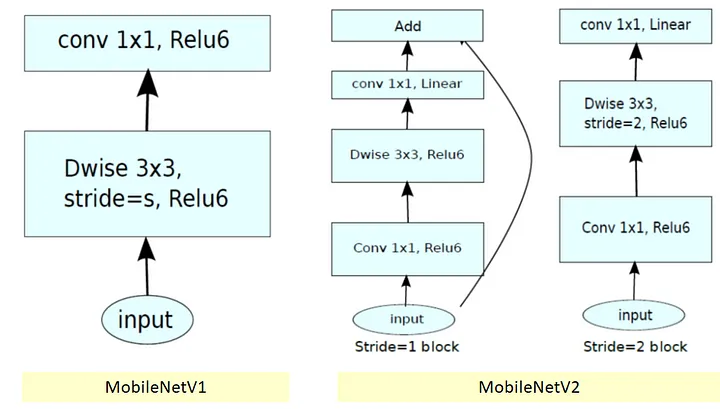

In [38]:
import torch
import torch.nn as nn
import math
from torchsummary import summary

In [39]:
def conv3x3(c_in,c_out,stride):
    return nn.Sequential(
        nn.Conv2d(c_in,c_out,3,stride = stride,padding = 1,bias = False),
        nn.BatchNorm2d(c_out),
        nn.ReLU6(inplace = True)
    )

In [40]:
def conv1x1(c_in,c_out):
    return nn.Sequential(
        nn.Conv2d(c_in,c_out,kernel_size=1,stride = 1,padding = 0,bias = False),
        nn.BatchNorm2d(c_out),
        nn.ReLU6(inplace = True)
    )

In [41]:
def dwise_conv(c_in,stride= 1):
    return nn.Sequential(
        nn.Conv2d(c_in,c_in,kernel_size = 3,padding = 1,stride = stride,groups = c_in,bias = False),
        nn.BatchNorm2d(c_in),
        nn.ReLU6(inplace =True)
    )

In [42]:
class InvertedResidualBlock(nn.Module):
    def __init__(self,c_in,c_out,stride,expand_ratio):
        super().__init__()
        assert stride in [1, 2], 'Stride value is greater than 2'

        hidden_dim = round(c_in * expand_ratio)
        self.identity = stride == 1 and c_in == c_out

        layers = []
        if expand_ratio != 1:
            #pointwise convolution
            layers.append(conv1x1(c_in,hidden_dim))
        layers.extend([
            #dephtwise conv
            dwise_conv(hidden_dim,stride),

            #pointwise linear -> no relu
            nn.Sequential(
                nn.Conv2d(hidden_dim,c_out,kernel_size = 1,stride =1,padding = 0,bias = False),
                nn.BatchNorm2d(c_out)
            )
        ])
        self.layers = nn.Sequential(*layers)

    def forward(self,x):
        if self.identity:
            return x + self.layers(x)
        else:
            return self.layers(x)

In [43]:
input = torch.randn(3,3,224,224)

blk = InvertedResidualBlock(3,32,1,2)
blk(input).shape

torch.Size([3, 32, 224, 224])

Full archicture


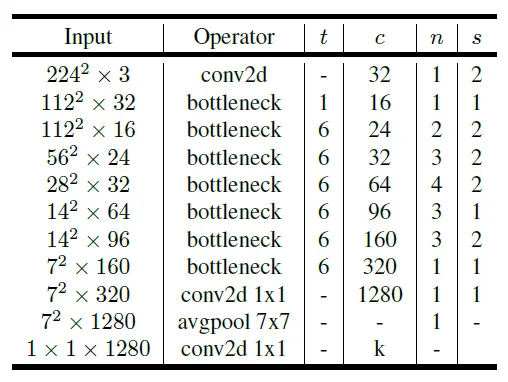

In [52]:
class MobileNetV2(nn.Module):
    def __init__(self,c_in,n_classes = 10):
        super(MobileNetV2,self).__init__()
        self.configs=[
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1]
        ]
        #t: expansion factor, c: number of output channels, n: repeating number, s: stride
        self.stem_conv = conv3x3(c_in,32,stride = 2)
        layers = []
        c_in = 32
        for t,c,n,s in self.configs:
            for i in range(n):
                stride = s if i==0 else 1
                layers.append(InvertedResidualBlock(c_in,c,stride =s,expand_ratio = t ))
                c_in = c
        self.layers = nn.Sequential(*layers)
        self.last_conv = conv1x1(c_in,1280)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280,n_classes)
        )
        self._initialize_weights()
    def forward(self,x):
        out = self.stem_conv(x)
        out = self.layers(out)
        out = self.last_conv(out)
        out = self.avg_pool(out)
        out = out.view(-1,1280)
        out = self.classifier(out)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


In [53]:
blk = MobileNetV2(3)
#input = torch.randn(3,3,224,224)
summary(blk,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
InvertedResidualBlock-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 